This code was based on in the following references:

[1] "Modelling the Social Interactions in Grey Wolf Optimizer" published in 2016 by Rodrigo C. Lira, Mariana Macedo, Hugo Valadares Siqueira, Ronaldo Menezes and Carmelo Bastos-Filho

[2] D. P. F. Cruz, R. D. Maia, and L. N. de Castro, “A framework for the analysis and synthesis of swarm intelligence algorithms,” Journal of Experimental & Theoretical Artificial Intelligence, vol. 0, no. 0, pp. 1–23, 2020.

[3] M. Oliveira, C. J. A. Bastos-Filho, and R. Menezes, “Using network science to assess particle swarm optimizers,” Social Network Analysis and Mining, vol. 5, no. 1, p. 3, Jan. 2015.

### Imports

In [1]:
import os
import sys
import csv
import random
import copy
import math
import time
import json
import tempfile
import argparse
import datetime
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import ipywidgets as widgets
import seaborn as sns
from collections import Counter
from random import randint
from scipy.stats import entropy
from IPython.display import display, HTML
from google.colab import drive, files
%matplotlib inline
plt.rcParams["figure.figsize"] = (18,9)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
warnings.filterwarnings("ignore")

### Connection google drive

In [2]:
drive.mount('/content/drive', force_remount=True) #  Connect to drive
FOLDERNAME = 'POLI/decimo/tcc/Algoritms/IN-abs/' #  Set folder that have the datasts
assert FOLDERNAME is not None, "[!] Enter the foldername."
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME)) #  Locale the foldeer

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/POLI/decimo/tcc/Algoritms/IN-abs


# Analysis Portrait and Kullback

## Functions to use in analysis

### radioData

In [3]:
radioData = widgets.RadioButtons(
    options=['data_normalized', 'data'],
    value='data_normalized', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Valor Normalizado ou Bruto:',
    disabled=False
)

radioData

RadioButtons(description='Valor Normalizado ou Bruto:', options=('data_normalized', 'data'), value='data_norma…

### Portrait and Entropy

In [4]:
def portrait_cpp(graph, fname=None, keepfile=False):
    """Compute and generate portrait of graph using compiled B_matrix
    executable.
    
    Return matrix B where B[i,j] is the number of starting nodes in graph with
    j nodes in shell i
    """
    # file to save to:
    f = fname
    if fname is None:
        f = next(tempfile._get_candidate_names())
    
    # make sure nodes are 0,...,N-1 integers:
    graph = nx.convert_node_labels_to_integers(graph)
    
    # write edgelist:
    nx.write_edgelist(graph, f+".edgelist", data=False)
    
    # make B-matrix:
    os.system("./B_matrix {}.edgelist {}.Bmat > /dev/null".format(f, f))
    portrait = np.loadtxt("{}.Bmat".format(f))
    
    # clean up:
    if not keepfile:
        os.remove(f+".edgelist")
        os.remove(f+".Bmat")
    
    return portrait


def portrait_py(graph):
    """Return matrix B where B[i,j] is the number of starting nodes in graph
    with j nodes in shell i.
    
    If this function is too slow, consider portrait_cpp() instead.
    """
    dia = 500 #nx.diameter(graph)
    N = graph.number_of_nodes()
    # B indices are 0...dia x 0...N-1:
    B = np.zeros((dia+1,N)) 
    
    max_path = 1
    adj = graph.adj
    for starting_node in graph.nodes():
        nodes_visited = {starting_node:0}
        search_queue = [starting_node]
        d = 1
        while search_queue:
            next_depth = []
            extend = next_depth.extend
            for n in search_queue:
                l = [i for i in adj[n] if i not in nodes_visited] 
                extend(l)
                for j in l:
                    nodes_visited[j] = d
            search_queue = next_depth
            d += 1
            
        node_distances = nodes_visited.values()
        max_node_distances = max(node_distances)
        
        curr_max_path = max_node_distances
        if curr_max_path > max_path:
            max_path = curr_max_path
        
        # build individual distribution:
        dict_distribution = dict.fromkeys(node_distances, 0)
        for d in node_distances:
            dict_distribution[d] += 1
        # add individual distribution to matrix:
        for shell,count in dict_distribution.items():
            B[shell][count] += 1
        
        # HACK: count starting nodes that have zero nodes in farther shells
        max_shell = dia
        while max_shell > max_node_distances:
            B[max_shell][0] += 1
            max_shell -= 1
    
    return B[:max_path+1,:]


portrait = portrait_py
#portrait = portrait_cpp


def weighted_portrait(G, paths=None, binedges=None):
    """Compute weighted portrait of G, using Dijkstra's algorithm for finding
    shortest paths. G is a networkx object.
    
    Return matrix B where B[i,j] is the number of starting nodes in graph with
    j nodes at distance d_i <  d < d_{i+1}.
    """
    # all pairs path lengths
    if paths is None:
        paths = list(nx.all_pairs_dijkstra_path_length(G))
    
    if binedges is None:
        unique_path_lengths  = _get_unique_path_lengths(G, paths=paths)
        sampled_path_lengths = np.percentile(unique_path_lengths, np.arange(0, 101, 1))
    else:
        sampled_path_lengths = binedges
    UPL = np.array(sampled_path_lengths)
    
    l_s_v = []
    for i,(s,dist_dict) in enumerate(paths):
        distances = np.array(list(dist_dict.values()))
        s_v,e = np.histogram(distances, bins=UPL)
        l_s_v.append(s_v)
    M = np.array(l_s_v)
    
    B = np.zeros((len(UPL)-1, G.number_of_nodes()+1))
    for i in range(len(UPL)-1):
        col = M[:,i] # ith col = numbers of nodes at d_i <= distance < d_i+1
        for n,c in Counter(col).items():
            B[i,n] += c
    
    return B


def _get_unique_path_lengths(graph, paths=None):
    if paths is None:
        paths = list(nx.all_pairs_dijkstra_path_length(graph))

    unique_path_lengths = set()
    for starting_node,dist_dict in paths:
        unique_path_lengths |= set(dist_dict.values())
    unique_path_lengths = sorted(list(unique_path_lengths))
    return unique_path_lengths


def pad_portraits_to_same_size(B1,B2):
    """Make sure that two matrices are padded with zeros and/or trimmed of
    zeros to be the same dimensions.
    """
    ns,ms = B1.shape
    nl,ml = B2.shape
    
    # Bmats have N columns, find last *occupied* column and trim both down:
    lastcol1 = max(np.nonzero(B1)[1])
    lastcol2 = max(np.nonzero(B2)[1])
    lastcol = max(lastcol1,lastcol2)
    B1 = B1[:,:lastcol+1]
    B2 = B2[:,:lastcol+1]
    
    BigB1 = np.zeros((max(ns,nl), lastcol+1))
    BigB2 = np.zeros((max(ns,nl), lastcol+1))
    
    BigB1[:B1.shape[0],:B1.shape[1]] = B1
    BigB2[:B2.shape[0],:B2.shape[1]] = B2
    
    return BigB1, BigB2


def _graph_or_portrait(X):
    """Check if X is a nx (di)graph. If it is, get its portrait. Otherwise
    assume it's a portrait and just return it.
    """
    if isinstance(X, (nx.Graph, nx.DiGraph)):
        return portrait(X)
    return X


def portrait_divergence(G, H):
    """Compute the network portrait divergence between graphs G and H."""
    
    BG = _graph_or_portrait(G)
    BH = _graph_or_portrait(H)
    BG, BH = pad_portraits_to_same_size(BG,BH)
    
    L, K = BG.shape
    V = np.tile(np.arange(K),(L,1))
    
    XG = BG*V / (BG*V).sum()
    XH = BH*V / (BH*V).sum()
    
    # flatten distribution matrices as arrays:
    P = XG.ravel()
    Q = XH.ravel()
    
    # lastly, get JSD:
    M = 0.5*(P+Q)
    KLDpm = entropy(P, M, base=2)
    KLDqm = entropy(Q, M, base=2)
    JSDpq = 0.5*(KLDpm + KLDqm)
    
    return JSDpq


def portrait_divergence_weighted(G,H, bins=None, binedges=None):
    """Network portrait divergence between two weighted graphs.
    
    bins = width of bins in percentiles
    binedges = vector of bin edges
    bins and binedges are mutually exclusive
    """
    
    # get joint binning:
    paths_G = list(nx.all_pairs_dijkstra_path_length(G))
    paths_H = list(nx.all_pairs_dijkstra_path_length(H))
    
    # get bin_edges in common for G and H:
    if binedges is None:
        if bins is None:
            bins = 1
        UPL_G = set(_get_unique_path_lengths(G, paths=paths_G))
        UPL_H = set(_get_unique_path_lengths(H, paths=paths_H))
        unique_path_lengths = sorted(list(UPL_G | UPL_H))
        binedges = np.percentile(unique_path_lengths, np.arange(0, 101, bins))
    
    # get weighted portraits:
    BG = weighted_portrait(G, paths=paths_G, binedges=binedges)
    BH = weighted_portrait(H, paths=paths_H, binedges=binedges)
    
    return portrait_divergence(BG, BH)


class CustomFormatter(argparse.ArgumentDefaultsHelpFormatter, argparse.RawDescriptionHelpFormatter):
    pass

### Load data and show results

In [5]:
dim = [15, 30]
metrics = ['pd', 'kd']
objective_functions = ["Sphere", "Rosenbrock", "Rastrigin", "Schwefel", "Griewank", "Ackley"]
font_size_out = 10
optimizer = "VGWO"
filepath = os.path.dirname(os.path.abspath('IN-abs'))
data_key = radioData.value

def sum_in(np_in):
  sum_np = np.zeros(np_in[0].shape)
  for i, t in enumerate(np_in):
    sum_np += t
  return sum_np

def get_pd_kd(data, limit_exec):
  result = {'pd': np.zeros((limit_exec, limit_exec)), 'kd': np.zeros((limit_exec, limit_exec))}
  for sim1 in range(0, limit_exec):
    for sim2 in range(0, limit_exec):
      result_sim1 = data[sim1][data_key]
      result_sim2 = data[sim2][data_key]
      result['pd'][sim1][sim2] = portrait_divergence(result_sim1, result_sim2)
      result['kd'][sim1][sim2] = entropy(np.hstack(result_sim1), np.hstack(result_sim2))

  return result

def exec_func_graph(d, opt, limit_exec=1, until=None):
  fig, axs = plt.subplots(ncols=len(objective_functions), nrows=2, figsize=(28,7))
  fig.subplots_adjust(wspace=0.1, hspace=.2)

  for col, func in enumerate(objective_functions):
    file_json = open(f"{filepath}/{d}d/{opt}_{func}_exec.json")
    exec_json = json.load(file_json)["array"]
    results = []
    for i, e in enumerate(exec_json[:limit_exec]):
      best_fit = e['alpha_scores'][-1]
      best_pos = e['alpha_positions'][-1]
      ins = np.array(e['in'])
      data = sum_in(ins[:until] if until else ins)
      total_ins = ins / np.sqrt((np.sum(ins**2)))
      # total_ins = np.rot90(total_ins, k=1)
      normalized_data = sum_in(total_ins[:until] if until else total_ins)
      # normalized_data = total_in / np.sqrt((np.sum(total_in**2)))
      dict_data = {
          'data': data,
          'data_normalized': normalized_data,
          'simulation': i,
      }
      results.append(dict_data)

    result = get_pd_kd(results, limit_exec)
    
    label = ord('A')
    for line, metric in enumerate(metrics):
      print(metric, 'euclidean', func)
      print(line, col)
      my_x = 0
      my_y = 1.1
      
      axs[line, col].text(my_x, my_y, f"{chr(label)} - {func}({d})", fontsize=1.5*font_size_out,
                          transform=axs[line, col].transAxes, bbox=dict(edgecolor='none', facecolor='w', alpha=0.5))
      if metric == 'pd':
          if col==0:
            showcbar=True
          axs[line, col] = sns.heatmap(result[metric], cmap="YlGnBu", vmin=0,
                                       vmax=1, xticklabels=True, yticklabels=True,
                                       cbar=showcbar, ax=axs[line, col],
                                       annot=False, annot_kws={"fontsize":font_size_out*1.5}, cbar_kws={'label': 'PD'})
          showcbar=True
          axs[line, col].figure.axes[-1].yaxis.label.set_size(font_size_out*1.5)

      elif metric == 'kd':
          if col==0:
            showcbar=True
          axs[line, col] = sns.heatmap(result[metric], cmap="YlOrRd", vmin=0,
                                       vmax=1,xticklabels=True, yticklabels=True,
                                       cbar=showcbar, ax=axs[line, col],
                                       annot=False, annot_kws={"fontsize":font_size_out*1.5}, cbar_kws={'label': 'KD'})
          showcbar=True
          axs[line, col].figure.axes[-1].yaxis.label.set_size(font_size_out*1.5)

      axs[line, col].invert_yaxis()
      
      tam = len(result[metric])
      labels = [""] * tam
      labels[0]= '1'
      labels[-1]= f'{tam}'
      axs[line,col].set_xticklabels(labels)
      axs[line,col].set_yticklabels(labels)
      axs[line,col].set_xlabel("Execution", fontsize=font_size_out*1.5)
      axs[line,col].set_ylabel("Execution", fontsize=font_size_out*1.5)
      cax = plt.gcf().axes[-1]
      cax.tick_params(labelsize=font_size_out*1.5)

      axs[line,col].tick_params('x', colors="black", labelsize=font_size_out*1.5)
      axs[line,col].tick_params('y', colors="black", labelsize=font_size_out*1.5)
      label+=1
      
  filename = f"PD_KD_SIMU_{opt}.png"
  plt.tight_layout()
  plt.show()
  #plt.savefig(heatmap_folder+filename)

## Show examples with 30 dim

pd euclidean Sphere
0 0
kd euclidean Sphere
1 0
pd euclidean Rosenbrock
0 1
kd euclidean Rosenbrock
1 1
pd euclidean Rastrigin
0 2
kd euclidean Rastrigin
1 2
pd euclidean Schwefel
0 3
kd euclidean Schwefel
1 3
pd euclidean Griewank
0 4
kd euclidean Griewank
1 4
pd euclidean Ackley
0 5
kd euclidean Ackley
1 5


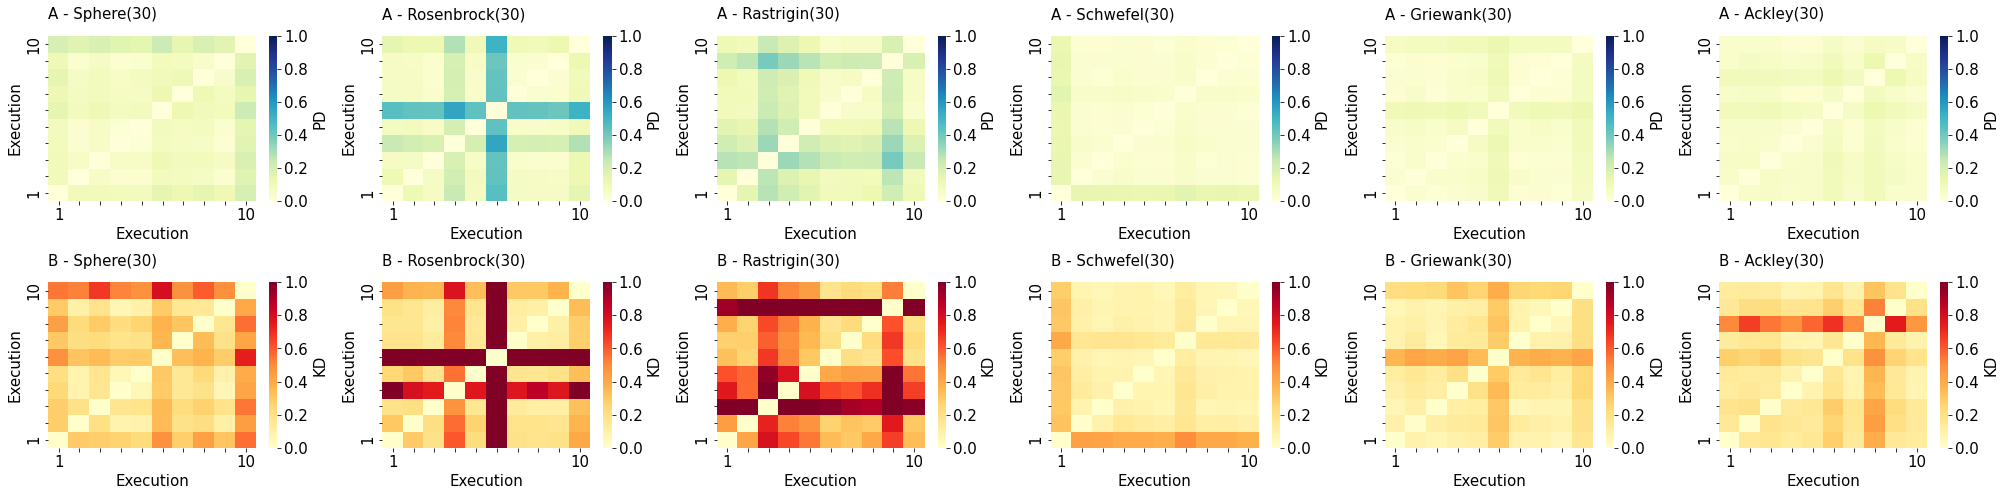

pd euclidean Sphere
0 0
kd euclidean Sphere
1 0
pd euclidean Rosenbrock
0 1
kd euclidean Rosenbrock
1 1
pd euclidean Rastrigin
0 2
kd euclidean Rastrigin
1 2
pd euclidean Schwefel
0 3
kd euclidean Schwefel
1 3
pd euclidean Griewank
0 4
kd euclidean Griewank
1 4
pd euclidean Ackley
0 5
kd euclidean Ackley
1 5


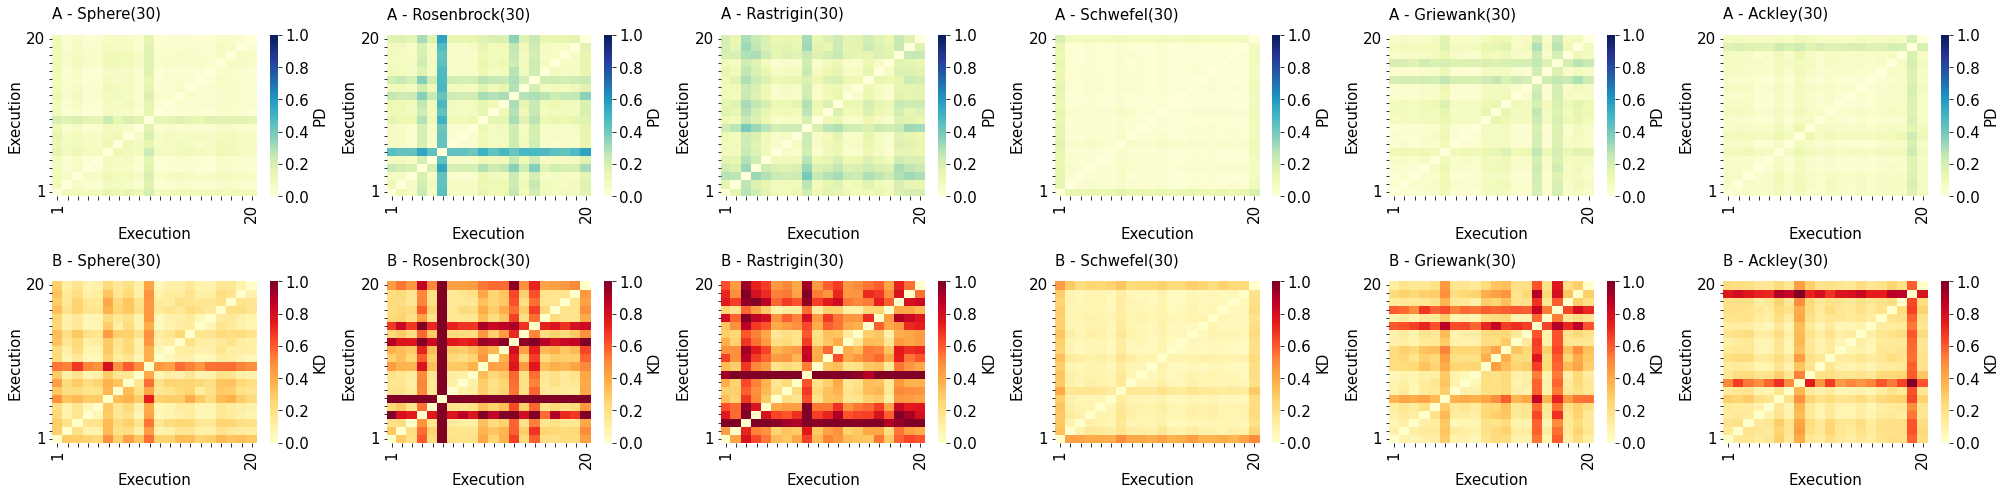

pd euclidean Sphere
0 0
kd euclidean Sphere
1 0
pd euclidean Rosenbrock
0 1
kd euclidean Rosenbrock
1 1
pd euclidean Rastrigin
0 2
kd euclidean Rastrigin
1 2
pd euclidean Schwefel
0 3
kd euclidean Schwefel
1 3
pd euclidean Griewank
0 4
kd euclidean Griewank
1 4
pd euclidean Ackley
0 5
kd euclidean Ackley
1 5


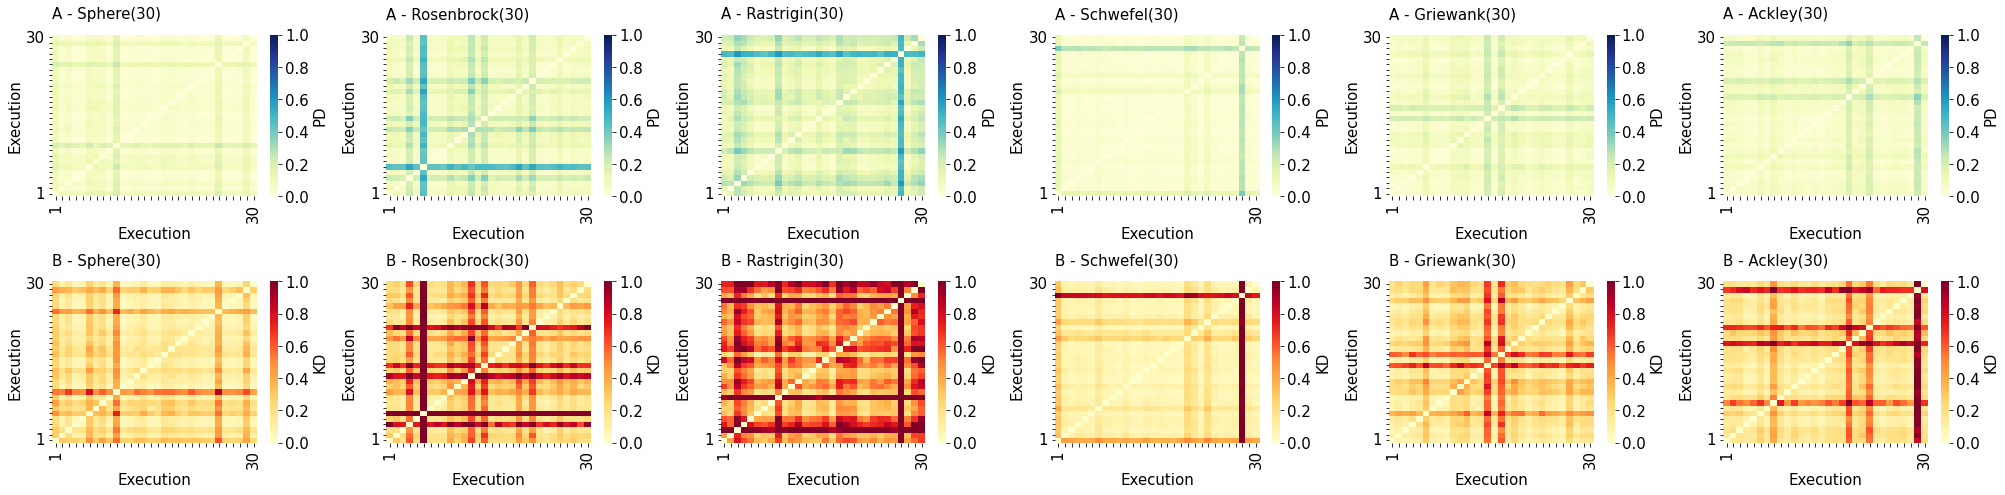

In [6]:
exec_func_graph(30, "VGWO", limit_exec=10)
exec_func_graph(30, "VGWO", limit_exec=20)
exec_func_graph(30, "VGWO", limit_exec=30)

## Show examples with 15 dim

pd euclidean Sphere
0 0
kd euclidean Sphere
1 0
pd euclidean Rosenbrock
0 1
kd euclidean Rosenbrock
1 1
pd euclidean Rastrigin
0 2
kd euclidean Rastrigin
1 2
pd euclidean Schwefel
0 3
kd euclidean Schwefel
1 3
pd euclidean Griewank
0 4
kd euclidean Griewank
1 4
pd euclidean Ackley
0 5
kd euclidean Ackley
1 5


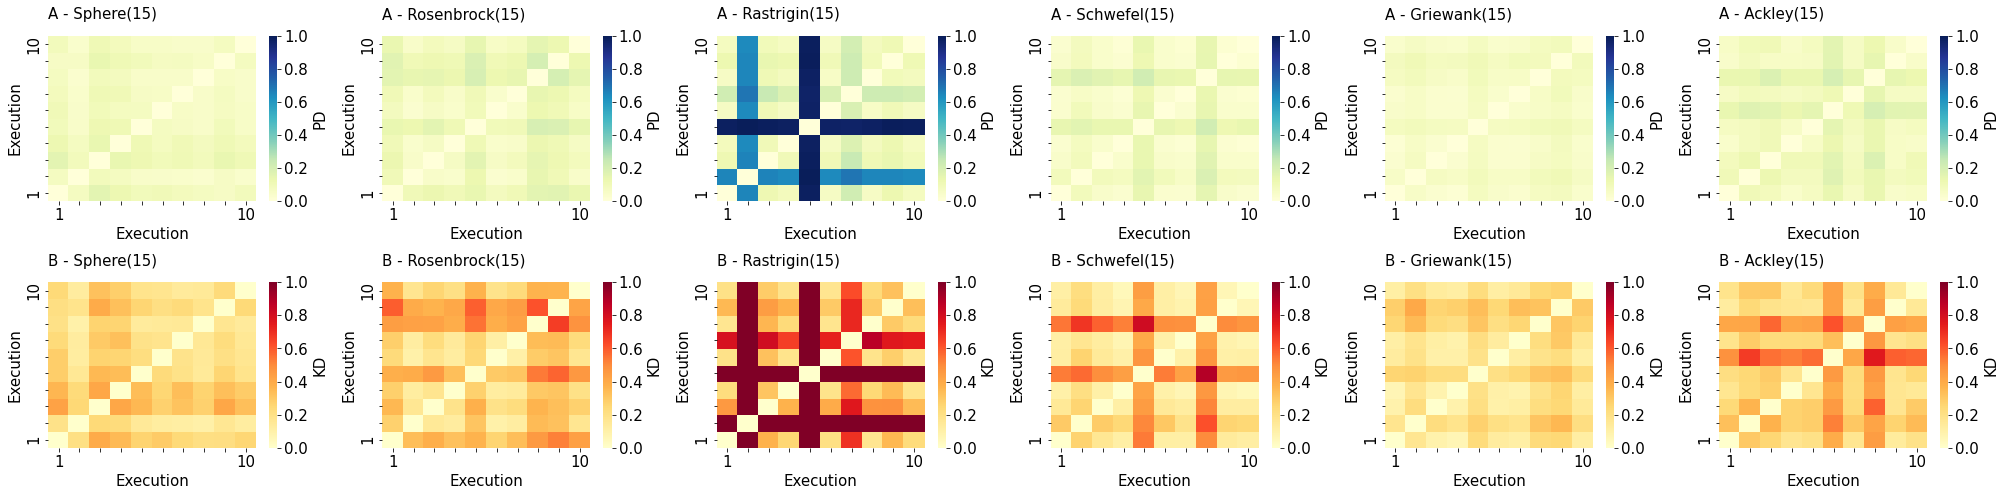

pd euclidean Sphere
0 0
kd euclidean Sphere
1 0
pd euclidean Rosenbrock
0 1
kd euclidean Rosenbrock
1 1
pd euclidean Rastrigin
0 2
kd euclidean Rastrigin
1 2
pd euclidean Schwefel
0 3
kd euclidean Schwefel
1 3
pd euclidean Griewank
0 4
kd euclidean Griewank
1 4
pd euclidean Ackley
0 5
kd euclidean Ackley
1 5


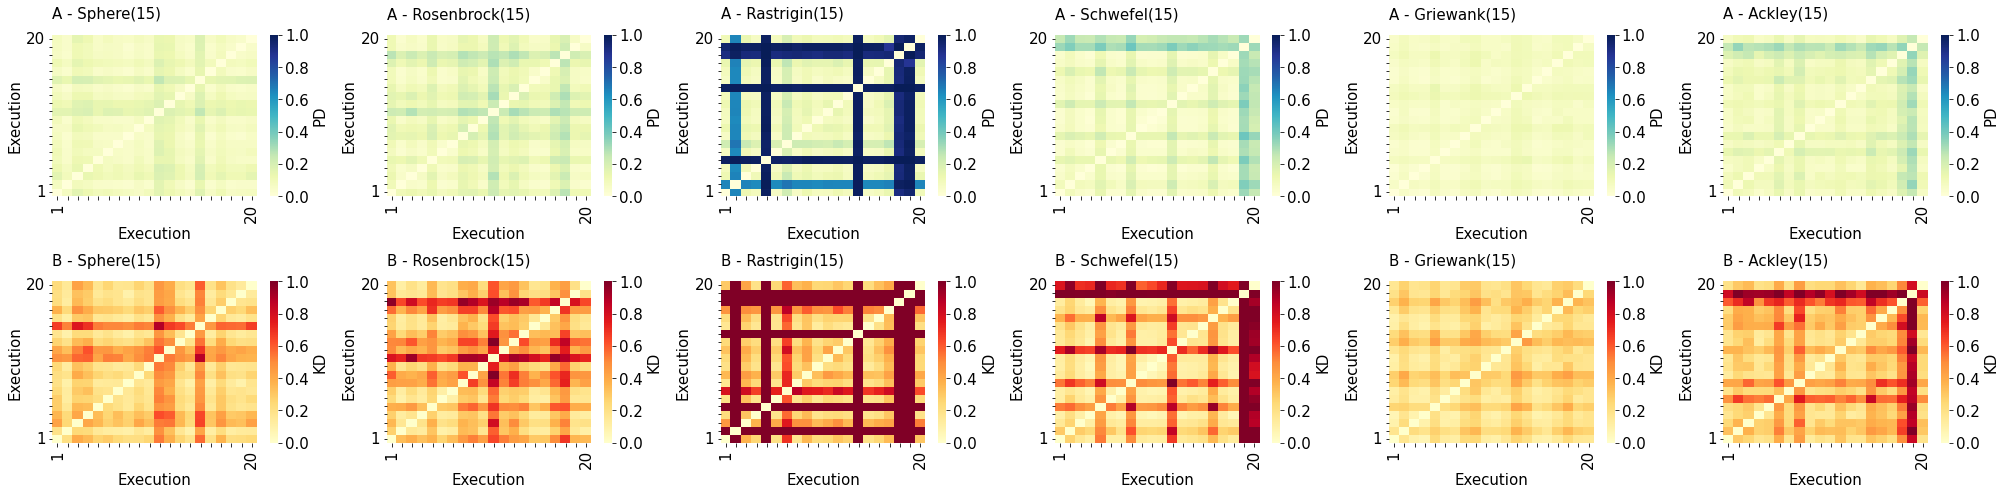

pd euclidean Sphere
0 0
kd euclidean Sphere
1 0
pd euclidean Rosenbrock
0 1
kd euclidean Rosenbrock
1 1
pd euclidean Rastrigin
0 2
kd euclidean Rastrigin
1 2
pd euclidean Schwefel
0 3
kd euclidean Schwefel
1 3
pd euclidean Griewank
0 4
kd euclidean Griewank
1 4
pd euclidean Ackley
0 5
kd euclidean Ackley
1 5


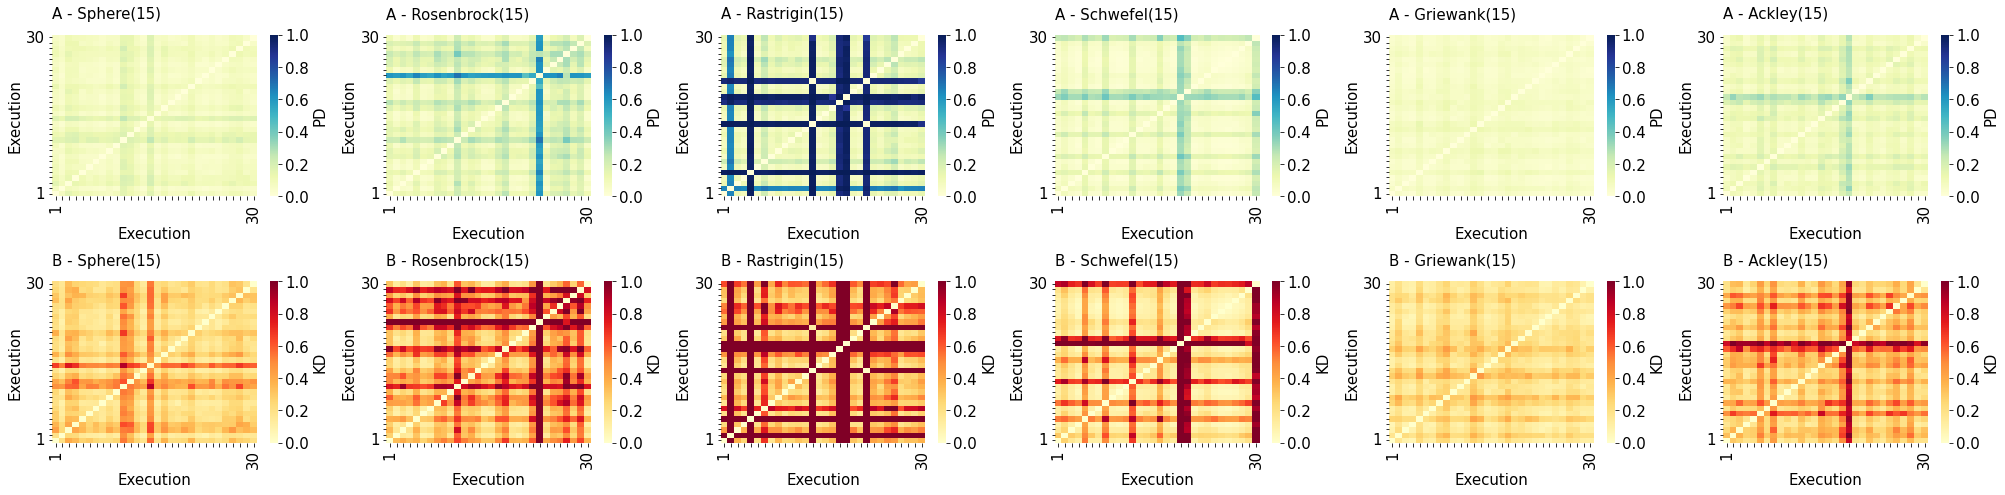

In [7]:
exec_func_graph(15, "VGWO", limit_exec=10)
exec_func_graph(15, "VGWO", limit_exec=20)
exec_func_graph(15, "VGWO", limit_exec=30)